In [1]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

## 1. Tiền xử lý dữ liệu

In [2]:
# Đọc từng file từ thư mục MXH_Dataset
train_df = pd.read_csv("../Dataset/train.csv")
segment_status_df = pd.read_csv("../Dataset/segment_status.csv")


In [3]:
# Kiểm tra số dòng, số cột của từng file
for name, df in [("segment_status", segment_status_df), 
                 ("train", train_df)]:
    print(f"{name}: {df.info}")

segment_status: <bound method DataFrame.info of          _id                updated_at  segment_id  velocity
0          0  2020-07-03T14:55:31.869Z       24845        20
1          1  2020-07-03T15:02:56.048Z       33923        10
2          2  2020-07-04T08:15:52.696Z       33824         5
3          3  2020-07-04T08:15:59.903Z       33824         5
4          4  2020-07-04T08:16:08.201Z       33824         5
...      ...                       ...         ...       ...
90933  90933  2021-04-22T06:52:39.280Z       52247         1
90934  90934  2021-04-22T06:52:52.501Z       52247         1
90935  90935  2021-04-22T06:53:02.335Z       52247         1
90936  90936  2021-04-22T06:53:14.294Z       52247         1
90937  90937  2021-04-22T06:53:27.300Z       52247         1

[90938 rows x 4 columns]>
train: <bound method DataFrame.info of          _id  segment_id        date  weekday        period LOS   s_node_id  \
0          0          26  2021-04-16        4   period_0_30   A   366428456

### 1.1 Xử lý dữ liệu thiếu

In [4]:
print("Missing values in train_df:\n", train_df.isnull().sum())
# Xử lý giá trị thiếu
train_df['max_velocity'] = train_df['max_velocity'].fillna(train_df['max_velocity'].mean())
train_df['street_name'] = train_df['street_name'].fillna('Unknown')

print("Missing values in train_df:\n", train_df.isnull().sum())

Missing values in train_df:
 _id                 0
segment_id          0
date                0
weekday             0
period              0
LOS                 0
s_node_id           0
e_node_id           0
length              0
street_id           0
max_velocity    28495
street_level        0
street_name         1
street_type         0
long_snode          0
lat_snode           0
long_enode          0
lat_enode           0
dtype: int64
Missing values in train_df:
 _id             0
segment_id      0
date            0
weekday         0
period          0
LOS             0
s_node_id       0
e_node_id       0
length          0
street_id       0
max_velocity    0
street_level    0
street_name     0
street_type     0
long_snode      0
lat_snode       0
long_enode      0
lat_enode       0
dtype: int64


In [5]:
# Chuyển đổi thời gian
train_df['date'] = pd.to_datetime(train_df['date'])
segment_status_df['updated_at'] = pd.to_datetime(segment_status_df['updated_at'])
train_df = train_df.sort_values('date')

### 1.2 Chuẩn hóa cột LOS

In [6]:
# Mã hóa nhãn LOS
le = LabelEncoder()
train_df['LOS_encoded'] = le.fit_transform(train_df['LOS']) 

### 1.3  Tạo đặc trưng node

In [7]:
# Tạo edge_index
edge_index = train_df[['s_node_id', 'e_node_id', 'segment_id']].drop_duplicates().dropna().astype(int)
node_ids = sorted(set(edge_index['s_node_id']).union(edge_index['e_node_id']))
node_id_to_index = {node_id: idx for idx, node_id in enumerate(node_ids)}
num_nodes = len(node_ids)

edge_index['s_node_idx'] = edge_index['s_node_id'].map(node_id_to_index)
edge_index['e_node_idx'] = edge_index['e_node_id'].map(node_id_to_index)
edge_index_torch = torch.tensor(edge_index[['s_node_idx', 'e_node_idx']].T.values, dtype=torch.int64)

# --- Tính thống kê velocity từ segment_status ---
velocity_stats = (
    segment_status_df
    .groupby('segment_id')['velocity']
    .agg(['mean', 'std'])
    .rename(columns={'mean': 'mean_velocity', 'std': 'std_velocity'})
)

# --- Encode LOS ---
los_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}
train_df['LOS_encoded'] = train_df['LOS'].map(los_map)

# --- Tính trung bình LOS theo segment ---
los_stats = (
    train_df.groupby('segment_id')['LOS_encoded']
    .agg(['mean'])
    .rename(columns={'mean': 'mean_LOS_encoded'})
)

# --- Phân bố LOS (optional) ---
los_dist = pd.crosstab(train_df['segment_id'], train_df['LOS_encoded'], normalize='index')
los_dist.columns = [f'los_{col}_ratio' for col in los_dist.columns]

# --- Gộp các feature theo segment_id ---
segment_features = pd.concat([velocity_stats, los_stats, los_dist], axis=1).fillna(0)

# --- Tạo node_features ---
node_degrees = pd.concat([
    edge_index['s_node_id'].value_counts(),
    edge_index['e_node_id'].value_counts()
]).groupby(level=0).sum()

node_features = []
for node_id in node_ids:
    connected_segments = edge_index[
        (edge_index['s_node_id'] == node_id) | (edge_index['e_node_id'] == node_id)
    ]['segment_id'].unique()

    # Lấy tất cả các feature liên quan đến segment_id
    features = segment_features.loc[segment_features.index.isin(connected_segments)]
    if not features.empty:
        agg_features = features.mean().values.tolist()
    else:
        agg_features = [0] * segment_features.shape[1]

    degree = node_degrees.get(node_id, 0)
    node_features.append([degree] + agg_features)

# # Chuẩn hoá node_features
# scaler = StandardScaler()

# # Chuẩn hoá chỉ các cột đặc trưng, không bao gồm degree
# node_features_scaled = scaler.fit_transform([feature[1:] for feature in node_features])

# # Gộp lại degree và các đặc trưng đã chuẩn hoá
# node_features_scaled = [[feature[0]] + list(node_feature) for feature, node_feature in zip(node_features, node_features_scaled)]

# Convert thành tensor
node_features = torch.tensor(node_features, dtype=torch.float32)

# Kiểm tra shape
print(node_features.shape)
print(node_features[:5])



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_i

torch.Size([11314, 10])
tensor([[ 1.0000, 32.0000,  7.2111,  1.0000,  0.3333,  0.3333,  0.3333,  0.0000,
          0.0000,  0.0000],
        [ 1.0000,  7.0000,  0.0000,  5.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000],
        [ 1.0000, 43.5000,  2.6458,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 2.0000, 27.6667,  2.5166,  2.0000,  0.0000,  0.1667,  0.6667,  0.1667,
          0.0000,  0.0000],
        [ 2.0000, 17.2500, 11.1689,  3.2500,  0.0000,  0.0000,  0.2500,  0.5000,
          0.0000,  0.2500]])


### 1.4 Tạo pivot table cho LOS

In [8]:
# Tạo los_pivot
los_pivot = train_df.pivot_table(
    index='segment_id',
    columns='date',
    values='LOS_encoded',
    aggfunc='mean'
).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).sort_index(axis=1)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_636\1558384230.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).sort_index(axis=1)


### 1.5 Chia tập train/test

In [9]:
all_dates = los_pivot.columns
split_idx = int(0.8 * len(all_dates))
train_dates = all_dates[:split_idx]
test_dates = all_dates[split_idx:]

### 1.6 Chia data_list

In [10]:
print("Các cột trong train_df:", train_df.columns)

Các cột trong train_df: Index(['_id', 'segment_id', 'date', 'weekday', 'period', 'LOS', 's_node_id',
       'e_node_id', 'length', 'street_id', 'max_velocity', 'street_level',
       'street_name', 'street_type', 'long_snode', 'lat_snode', 'long_enode',
       'lat_enode', 'LOS_encoded'],
      dtype='object')


In [11]:
from torch_geometric.data import Data, DataLoader

# Gom street_type hiếm thành "other"
threshold = 100  # Loại đường có dưới 100 mẫu
street_type_counts = train_df['street_type'].value_counts()
train_df['street_type_adjusted'] = train_df['street_type'].apply(
    lambda x: x if street_type_counts.get(x, 0) >= threshold else 'other'
)

# Mã hóa street_type_adjusted
le_street_type = LabelEncoder()
train_df['street_type_encoded'] = le_street_type.fit_transform(train_df['street_type_adjusted'].fillna('other'))

# Tiền tính đặc trưng để tối ưu tốc độ
length_means = train_df.groupby('segment_id')['length'].mean().to_dict()
velocity_means = segment_status_df.groupby('segment_id')['velocity'].mean().to_dict()
street_level_means = train_df.groupby('segment_id')['street_level'].mean().fillna(0).to_dict()

def create_datalist(dates):
    data_list = []
    for date in dates:
        edge_features = []
        targets = []
        los_values = los_pivot[date].reindex(edge_index['segment_id']).fillna(0)
        
        for idx, segment_id in enumerate(edge_index['segment_id']):
            avg_length = length_means.get(segment_id, 0)
            avg_velocity = velocity_means.get(segment_id, 0)
            street_level = street_level_means.get(segment_id, 0)
            los_encoded = los_values.iloc[idx]
            edge_features.append([avg_length, avg_velocity, street_level])  # 3 đặc trưng
            targets.append(int(los_encoded))
        
        edge_features = torch.tensor(edge_features, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.long)
        data = Data(
            x=node_features,
            edge_index=edge_index_torch,
            edge_attr=edge_features,  # edge_attr có 3 đặc trưng
            y=targets
        )
        data_list.append(data)
        if len(data_list) == 1:
            print("Sample edge_features:", edge_features[:5])
    return data_list

train_loader = DataLoader(create_datalist(train_dates), batch_size=4, shuffle=True)
test_loader = DataLoader(create_datalist(test_dates), batch_size=4, shuffle=False)

Sample edge_features: tensor([[78.0000, 10.0000,  4.0000],
        [73.0000, 16.0000,  2.0000],
        [89.0000, 25.2862,  4.0000],
        [67.0000, 13.0000,  4.0000],
        [15.0000, 10.8873,  4.0000]])


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Sample edge_features: tensor([[78.0000, 10.0000,  4.0000],
        [73.0000, 16.0000,  2.0000],
        [89.0000, 25.2862,  4.0000],
        [67.0000, 13.0000,  4.0000],
        [15.0000, 10.8873,  4.0000]])


## 2. Định nghĩa mô hình GRNN (GCN + LSTM)

In [12]:
from torch_geometric.nn import GCNConv
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F

# Chia train/validationx
train_indices = list(range(len(train_loader.dataset)))
val_size = int(0.2 * len(train_indices))
train_indices, val_indices = train_indices[val_size:], train_indices[:val_size]
train_subset = Subset(train_loader.dataset, train_indices)
val_subset = Subset(train_loader.dataset, val_indices)
train_loader = DataLoader(train_subset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=4, shuffle=False)

class GRNN_LSTM(nn.Module):
    def __init__(self, node_features_dim, hidden_dim, num_classes, edge_attr_dim=3, dropout_rate=0.7):
        super(GRNN_LSTM, self).__init__()
        self.gcn1 = GCNConv(node_features_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(hidden_dim * 2 + edge_attr_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, data_list):
        outputs = []
        h, c = None, None
        for data in data_list:
            x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
            x = self.gcn1(x, edge_index)
            x = self.bn1(x)
            x = F.relu(x)
            x = self.gcn2(x, edge_index)
            x = self.bn2(x)
            x = F.relu(x)
            x = self.dropout(x)
            s_node_idx, e_node_idx = edge_index
            edge_features = torch.cat([x[s_node_idx], x[e_node_idx], edge_attr], dim=-1)
            edge_features = edge_features.unsqueeze(0)
            edge_features, (h, c) = self.lstm(edge_features, (h, c)) if h is not None else self.lstm(edge_features)
            edge_features = edge_features.squeeze(0)
            out = self.fc(edge_features)
            outputs.append(out)
        return outputs

## 3. Huấn luyện mô hình

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Số lượng từng class theo thứ tự [A, B, C, D, E, F]
counts = np.array([13278, 4700, 3839, 3707, 3828, 4089], dtype=np.float32)
total = counts.sum()
class_weights = total / (len(counts) * counts)
class_weights = class_weights / class_weights.min()
# [1.00, 2.82, 3.46, 3.57, 3.47, 3.25]
weights = torch.tensor([5.8, 5.2, 5.2, 4.0, 5.0, 6.2], dtype=torch.float32).to(device)

# Khởi tạo mô hình
model = GRNN_LSTM(node_features_dim=10, hidden_dim=64, num_classes=len(le.classes_))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=4e-4)
criterion = nn.CrossEntropyLoss(weight=weights).to(device)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

# Huấn luyện
model.train()
best_val_loss = float('inf')
patience = 30
counter = 0
train_losses = []
val_losses = []
for epoch in range(50):
    model.train()
    total_train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model([data])
        loss = criterion(outputs[0], data.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    val_predictions = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model([data])
            loss = criterion(outputs[0], data.y)
            total_val_loss += loss.item()
            pred = torch.argmax(outputs[0], dim=1)
            val_predictions.extend(pred.cpu().tolist())
    avg_val_loss = total_val_loss / len(val_loader)
    val_pred_labels = le.inverse_transform(val_predictions)
    val_losses.append(avg_val_loss)
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"Phân phối nhãn dự đoán (Validation):")
    print(pd.Series(val_pred_labels).value_counts())

    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping!")
        break

[Epoch 1] Train Loss: 1.7375, Val Loss: 1.6624
Phân phối nhãn dự đoán (Validation):
A    190374
D       139
Name: count, dtype: int64
[Epoch 2] Train Loss: 1.5263, Val Loss: 1.4881
Phân phối nhãn dự đoán (Validation):
A    98059
D    82247
F     9960
C      228
E       19
Name: count, dtype: int64
[Epoch 3] Train Loss: 1.3755, Val Loss: 1.4238
Phân phối nhãn dự đoán (Validation):
A    82459
D    68879
F    38672
C      503
Name: count, dtype: int64
[Epoch 4] Train Loss: 1.2711, Val Loss: 1.3291
Phân phối nhãn dự đoán (Validation):
A    71345
D    69654
F    39824
C     8075
B     1140
E      475
Name: count, dtype: int64
[Epoch 5] Train Loss: 1.1560, Val Loss: 1.2308
Phân phối nhãn dự đoán (Validation):
D    63546
A    57133
F    35264
B    15143
C    13290
E     6137
Name: count, dtype: int64
[Epoch 6] Train Loss: 1.0504, Val Loss: 1.1505
Phân phối nhãn dự đoán (Validation):
D    55589
A    54278
F    30210
C    19765
B    19266
E    11405
Name: count, dtype: int64
[Epoch 7] Train Los

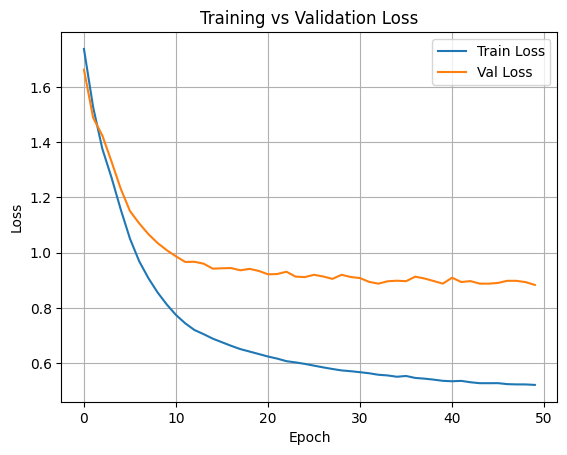

In [14]:
# Sau khi huấn luyện:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, le, device):
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    predictions =[] 
    targets = []

    if len(test_loader) == 0:
        print("Error: test_loader is empty!")
        return

    with torch.no_grad():
        for data in test_loader:
            try:
                data = data.to(device)
                output = model([data])[0]
                pred = torch.argmax(output, dim=1)
                predictions.extend(pred.cpu().tolist())
                targets.extend(data.y.cpu().tolist())
            except Exception as e:
                print(f"Error processing batch: {e}")
                continue

    if not predictions or not targets:
        print("Error: No predictions or targets collected!")
        return

    # Chuyển về nhãn gốc
    predicted_labels = le.inverse_transform(predictions)
    target_labels = le.inverse_transform(targets)

    # Phân phối nhãn
    print("📌 Phân phối nhãn thực tế (Test):")
    print(pd.Series(target_labels).value_counts())
    print("\n📌 Phân phối nhãn dự đoán (Test):")
    print(pd.Series(predicted_labels).value_counts())

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(target_labels, predicted_labels))

    # Confusion Matrix
    labels = le.classes_
    cm = confusion_matrix(target_labels, predicted_labels, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.title("🔍 Confusion Matrix - LOS")
    plt.show()

    # Hồi quy metrics
    predicted_values = le.transform(predicted_labels)
    target_values = le.transform(target_labels)
    mse = mean_squared_error(target_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(target_values, predicted_values)

    print("\n📈 Hồi quy Metrics (dựa trên giá trị số của nhãn):")
    print(f"🔹 MSE  : {mse:.4f}")
    print(f"🔹 RMSE : {rmse:.4f}")
    print(f"🔹 MAE  : {mae:.4f}")

    plt.hist(target_labels, bins=6, alpha=0.6, label="Thực tế")
    plt.hist(predicted_labels, bins=6, alpha=0.6, label="Dự đoán")
    plt.title("Phân phối Nhãn LOS: Thực tế vs Dự đoán")
    plt.xlabel("Nhãn LOS")
    plt.ylabel("Số lượng")
    plt.legend()
    plt.grid(True)
    plt.show()


## 4. Trực quan hóa kết quả

📌 Phân phối nhãn thực tế (Test):
A    67910
D    50352
E    36932
C    35553
F    32264
B    27664
Name: count, dtype: int64

📌 Phân phối nhãn dự đoán (Test):
A    67657
D    50600
E    38539
C    36522
F    29839
B    27518
Name: count, dtype: int64

📊 Classification Report:
              precision    recall  f1-score   support

           A       0.89      0.89      0.89     67910
           B       0.76      0.76      0.76     27664
           C       0.72      0.73      0.72     35553
           D       0.75      0.75      0.75     50352
           E       0.72      0.75      0.73     36932
           F       0.81      0.75      0.78     32264

    accuracy                           0.79    250675
   macro avg       0.77      0.77      0.77    250675
weighted avg       0.79      0.79      0.79    250675



C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


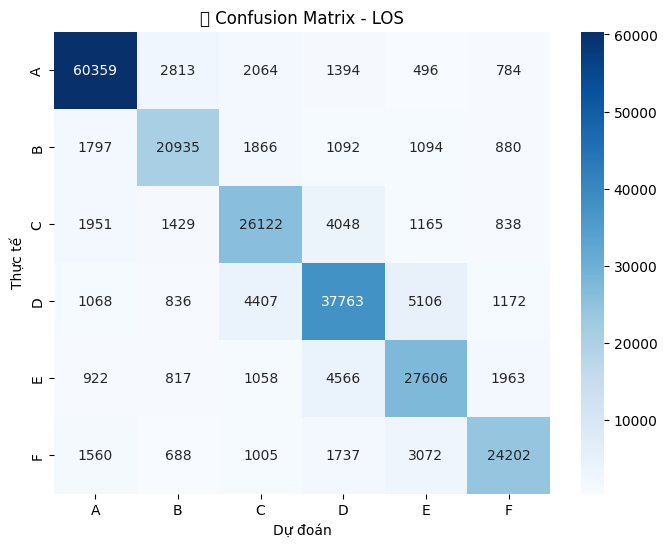


📈 Hồi quy Metrics (dựa trên giá trị số của nhãn):
🔹 MSE  : 0.9482
🔹 RMSE : 0.9737
🔹 MAE  : 0.3811


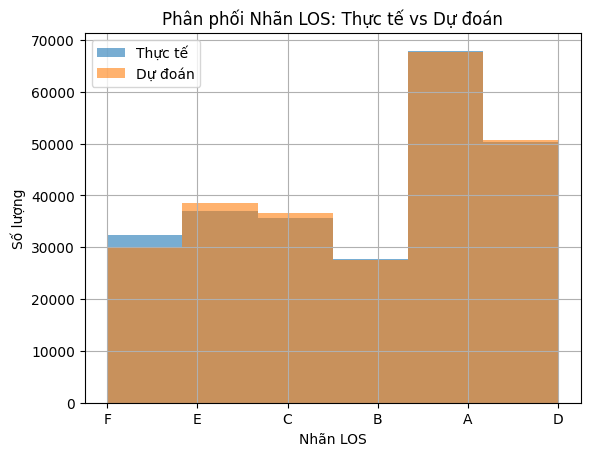

In [16]:
# Gọi hàm đánh giá
evaluate_model(model, test_loader, le, device)

In [17]:
5.8, 5.2, 5.2, 4.0, 5.0, 6.2

(5.8, 5.2, 5.2, 4.0, 5.0, 6.2)

## 5. debug

In [18]:
test_targets = []
for data in test_loader:
    test_targets.extend(data.y.cpu().tolist())
test_target_labels = le.inverse_transform(test_targets)
print("Phân phối nhãn thực tế (Test):")
print(pd.Series(test_target_labels).value_counts())

print("Train dates:", train_dates)
print("Test dates:", test_dates)
print("Giao nhau:", set(train_dates) & set(test_dates))

Phân phối nhãn thực tế (Test):
A    67910
D    50352
E    36932
C    35553
F    32264
B    27664
Name: count, dtype: int64
Train dates: DatetimeIndex(['2020-07-03', '2020-07-04', '2020-07-06', '2020-07-11',
               '2020-07-12', '2020-07-13', '2020-07-15', '2020-07-20',
               '2020-07-25', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-05',
               '2020-08-07', '2020-08-10', '2020-08-11', '2020-08-30',
               '2020-09-10', '2020-09-11', '2020-10-16', '2020-10-17',
               '2020-10-18', '2020-10-19', '2020-10-27', '2020-10-29',
               '2020-11-01', '2020-11-04', '2020-11-05', '2020-11-09',
               '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
            